In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

import keras
from keras.utils.np_utils import to_categorical
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from keras.layers import LeakyReLU
from keras.utils import plot_model
from sklearn.metrics import precision_recall_fscore_support


import xgboost as xgb

Using TensorFlow backend.
C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as

In [2]:
#https://matplotlib.org/3.1.0/gallery/pie_and_polar_charts/pie_and_donut_labels.html
def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d} )".format(pct, absolute)

def drawPieChart(label,data,title):
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
    
        ax.annotate(label[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
    plt.title(title)
    plt.show()

In [3]:
df=pd.read_csv("cr_loan2.csv")
df.reset_index(inplace=True)
print(df.columns)

indices=df[df['loan_status'].isnull()].index
df.drop(indices,inplace=True)

indices=df[df['person_emp_length'].isnull()].index
df.drop(indices,inplace=True)

df.dropna(inplace=True)


Index(['index', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')


In [4]:
df['loan_percent_income']=df['loan_percent_income'].astype('float')
df['loan_amnt']=df['loan_amnt'].astype('float')
df['person_income']=df['person_income'].astype('float')
df['loan_int_rate']=df['loan_int_rate'].astype('float')
df['loan_intent']=df['loan_intent'].astype(str)
df['loan_grade']=df['loan_grade'].astype(str)

filter=(df['person_emp_length']<40) & (df['person_income']<500000)
df=df[filter]


df['age_type']=df['person_age'].apply(lambda row: "teenager" if (row<20)
                                     else "young adult" if (row>=20) & (row<30)
                                    else "adult" if (row>=30) & (row < 50)
                                      else "senior"
                                     )

#encoder=LabelEncoder()
#df["person_home_ownership_enc"]=encoder.fit_transform(df["person_home_ownership"])
#df["loan_grade_enc"]=encoder.fit_transform(df["loan_grade"])
#df["cb_person_default_on_file_enc"]=encoder.fit_transform(df["cb_person_default_on_file"])

#rint(df.info())
cred_num  =df.select_dtypes(exclude=['object'])
cred_cat = df.select_dtypes(include=['object'])
ohe=pd.get_dummies(cred_cat)
df=pd.concat([df,ohe],axis=1)

print(df.columns)

Index(['index', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length', 'age_type',
       'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_A',
       'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E',
       'loan_grade_F', 'loan_grade_G', 'cb_person_default_on_file_N',
       'cb_person_default_on_file_Y', 'age_type_adult', 'age_type_senior',
       'age_type_young adult'],
      dtype='object')


In [5]:
interest_rate=df['loan_int_rate'].mean()
#print(interest_rate)
indices=df[df['loan_int_rate'].isnull()].index
filter=df.index.isin(indices)
indices=df['loan_int_rate'][filter].index

df.loc[indices,'loan_int_rate']=float(interest_rate)
#print(df[df['loan_int_rate']>=interest_rate])

In [6]:
print(df['person_home_ownership'].unique())
indices=df[df['person_home_ownership'].isnull()].index
df.loc[indices,'person_home_ownership']='OTHER'

['OWN' 'MORTGAGE' 'RENT' 'OTHER']


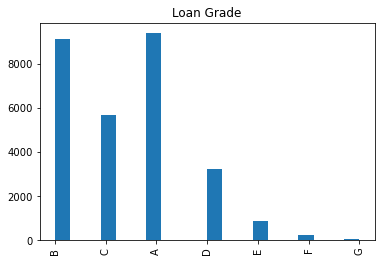

In [7]:
plt.hist(x=df['loan_grade'],bins=20)
plt.xticks(rotation=90)
plt.title("Loan Grade")
plt.show()

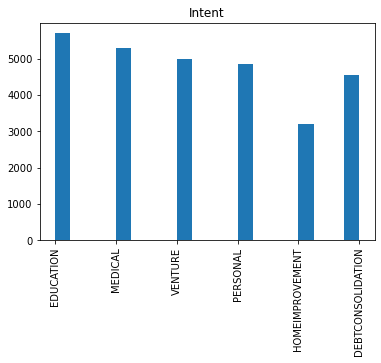

In [8]:
plt.hist(x=df['loan_intent'],bins=20)
plt.xticks(rotation=90)
plt.title("Intent")
plt.show()
#, 'loan_grade'

<AxesSubplot:ylabel='loan_intent-person_age'>

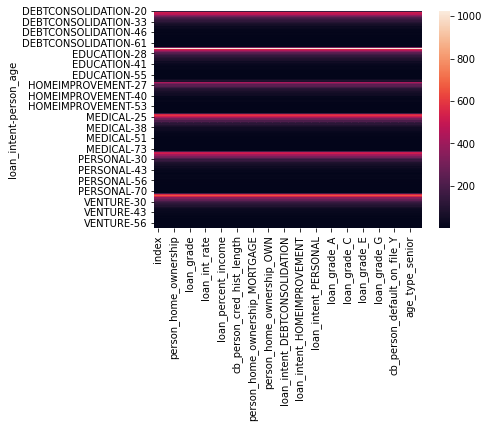

In [9]:
grouped=df.groupby(['loan_intent','person_age']).count()
#print(grouped)
sns.heatmap(grouped)

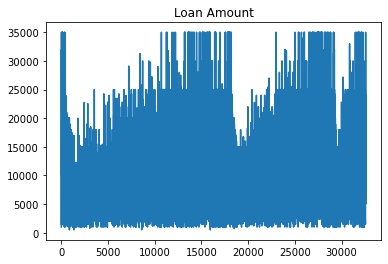

average loan amount 9648.410060868957


In [10]:
df['loan_amnt'].plot()
plt.title('Loan Amount')
plt.show()
print("average loan amount {}".format(df['loan_amnt'].mean()))

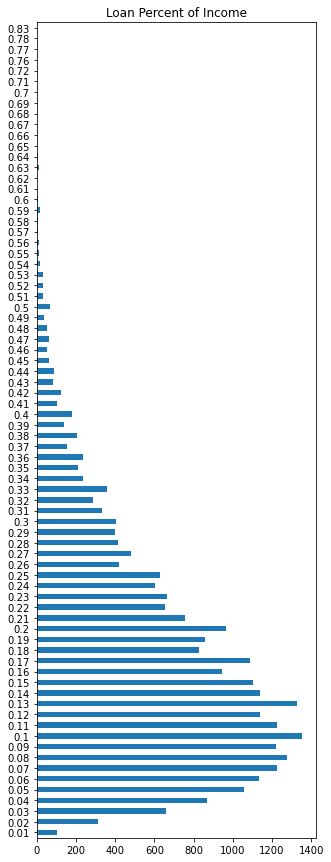

In [11]:
plt.figure(figsize=(5,15))
df['loan_percent_income'].value_counts().sort_index().plot(kind='barh')
plt.title('Loan Percent of Income')
plt.show()

In [12]:
print("Credit risk is the possiblity that the borrower will not repay the loan")

Credit risk is the possiblity that the borrower will not repay the loan


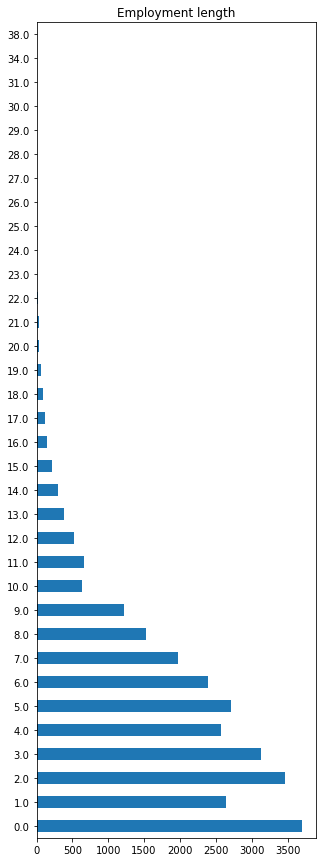

In [13]:
plt.figure(figsize=(5,15))
df['person_emp_length'].value_counts().sort_index().plot(kind='barh')
plt.title("Employment length")
plt.show()

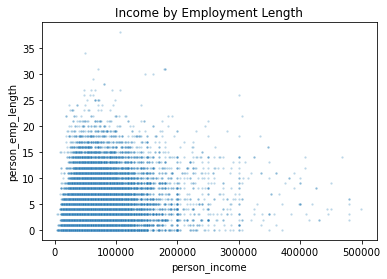

In [14]:
sns.scatterplot(x='person_income',y='person_emp_length',data=df,alpha=0.3,s=5)
plt.title('Income by Employment Length')
plt.show()

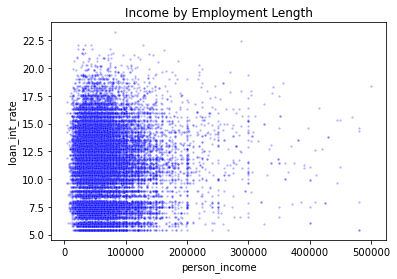

In [15]:
sns.scatterplot(x='person_income',y='loan_int_rate',color="blue", data=df,alpha=0.3,s=5)
plt.title('Income by Employment Length')
plt.show()

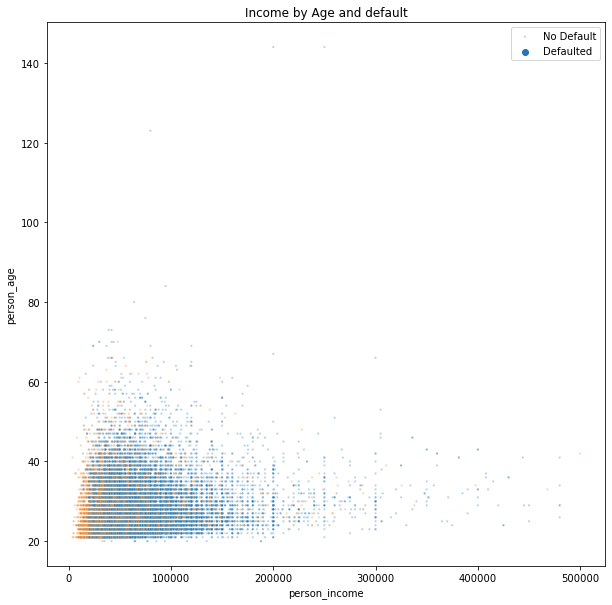

Ages 30 to 50 have higher incomes. Afterwhich incomes drop off in frequency


In [16]:
colors=['red','green']
plt.figure(figsize=(10,10))
sns.scatterplot(x='person_income',y='person_age',hue=df['loan_status'], 
                cmap = ListedColormap(colors),
                data=df,alpha=0.3,s=5)
plt.title('Income by Age and default')
plt.legend(['No Default', 'Defaulted'])
plt.show()

print("Ages 30 to 50 have higher incomes. Afterwhich incomes drop off in frequency")

<Figure size 432x288 with 0 Axes>

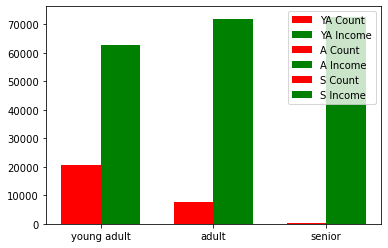

young adult (20-29) adult (30-49), senior (50-)


In [17]:
age_types=['young adult','adult','senior']
grouped=df.groupby('age_type')['person_income'].count()
grouped2=df.groupby('age_type')['person_income'].mean()

young_adult_count=(grouped['young adult'])
young_adult_income=(grouped2['young adult'])

adult_count=(grouped['adult'])
adult_income=(grouped2['adult'])

senior_count=(grouped['senior'])
senior_income=(grouped2['senior'])


plt.clf()
bar_width=.35
index=np.arange(len(age_types))
fig,ax=plt.subplots()
ya_count_bar=ax.bar(index[0]-(bar_width/2),young_adult_count,bar_width,label="YA Count",color='red')
ya_income_ba=ax.bar(index[0]+(bar_width/2),young_adult_income,bar_width,label="YA Income",color='green')

a_count_bar=ax.bar(index[1]-(bar_width/2),adult_count,bar_width,label="A Count",color='red')
a_income_ba=ax.bar(index[1]+(bar_width/2),adult_income,bar_width,label="A Income",color='green')

s_count_bar=ax.bar(index[2]-(bar_width/2),senior_count,bar_width,label="S Count",color='red')
s_income_ba=ax.bar(index[2]+(bar_width/2),senior_income,bar_width,label="S Income",color='green')

ax.set_xticks(index)
ax.set_xticklabels(age_types)

#plt.bar(grouped.index,grouped.values,label="Count",color='red')
#plt.bar(grouped2.index,grouped2.values,label="Avg Income", color="green")
plt.legend()

#plt.legend(['young adult (20-29)','adult (30-49), senior (50-)'])
plt.show()
print('young adult (20-29)','adult (30-49), senior (50-)')

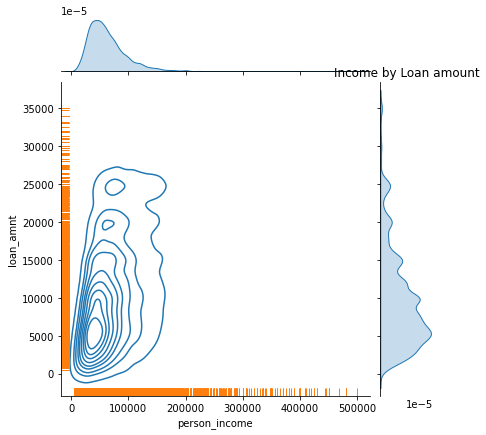

In [18]:
g=sns.JointGrid(data=df, x='person_income', y='loan_amnt')
g=g.plot_joint(sns.kdeplot)
g=g.plot_joint(sns.rugplot)
g=g.plot_marginals(sns.kdeplot,shade=True)
plt.title("Income by Loan amount")
plt.show()

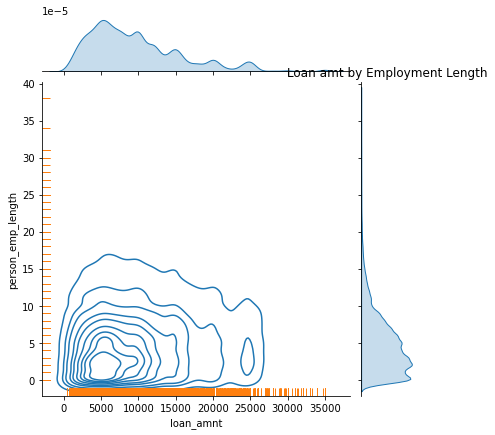

In [19]:
g=sns.JointGrid(data=df, x='loan_amnt', y='person_emp_length')
g=g.plot_joint(sns.kdeplot)
g=g.plot_joint(sns.rugplot)
g=g.plot_marginals(sns.kdeplot,shade=True)
plt.title("Loan amt by Employment Length")
plt.show()

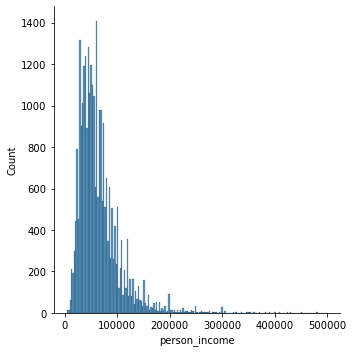

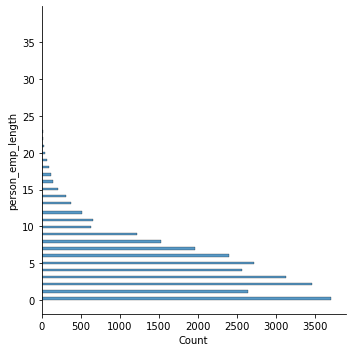

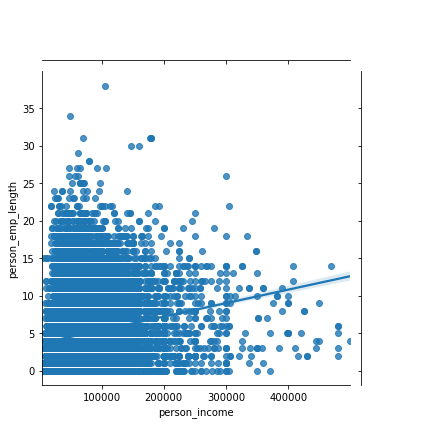

In [20]:
g=sns.JointGrid(data=df, x='person_income', y='person_emp_length')
#g=g.plot_joint(sns.kdeplot)
#g=g.plot_marginals(sns.kdeplot,shade=True)
g.plot(sns.regplot, sns.displot)
plt.show()

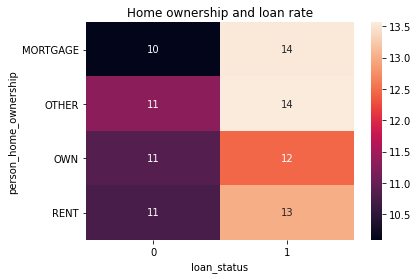

In [21]:
ct=pd.crosstab(df['person_home_ownership'],df['loan_status'],values=df['loan_int_rate'], aggfunc='mean').round(2)
sns.heatmap(ct,annot=True)
plt.title("Home ownership and loan rate")
plt.show()

<AxesSubplot:xlabel='loan_status', ylabel='loan_intent'>

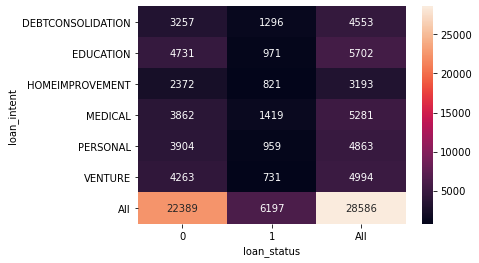

In [22]:
# Create a cross table of the loan intent and loan status
ct=(pd.crosstab(df["loan_intent"], df["loan_status"], margins = True))
sns.heatmap(ct,annot=True,fmt="g")

<AxesSubplot:xlabel='loan_status', ylabel='person_home_ownership'>

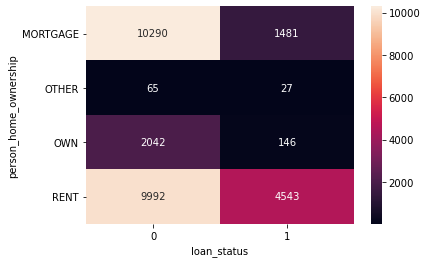

In [23]:
ct=(pd.crosstab(df["person_home_ownership"], df["loan_status"],df["loan_grade"],aggfunc='count'))
sns.heatmap(ct,annot=True,fmt="g")

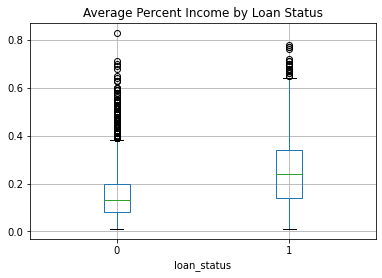

The average percentage of income for defaults is higher


In [24]:
df.boxplot(column = ["loan_percent_income"], by = "loan_status")
plt.title('Average Percent Income by Loan Status')
plt.suptitle('')
plt.show()

print("The average percentage of income for defaults is higher")

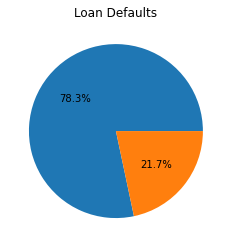

In [25]:
plt.pie(df['loan_status'].value_counts(),autopct='%1.1f%%')
plt.title('Loan Defaults')
plt.show()


In [26]:
pipeline = Pipeline([
    #('std', StandardScaler),
    ('lr', LogisticRegression(solver='lbfgs',penalty='l2',C=.1,tol=0.001,max_iter=100))
])

In [27]:
COLUMNS=[x for x in df.select_dtypes(exclude=['object']).columns if x!="loan status"]
print(COLUMNS)
X=df[COLUMNS]

y=df['loan_status']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,random_state=123)
pipeline['lr'].fit(X_train,y_train)



['index', 'person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F', 'loan_grade_G', 'cb_person_default_on_file_N', 'cb_person_default_on_file_Y', 'age_type_adult', 'age_type_senior', 'age_type_young adult']


LogisticRegression(C=0.1, tol=0.001)

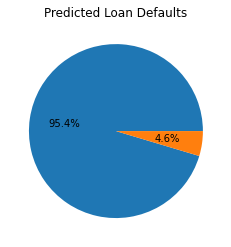

In [28]:
y_pred_prob=pipeline['lr'].predict_proba(X_test)

predictions=pipeline['lr'].predict(X_test)

plt.pie(pd.Series(predictions).value_counts(),autopct='%1.1f%%')
plt.title('Predicted Loan Defaults')
plt.show()


In [29]:
# Function to sort the list by second item of tuple
def Sort_Tuple(tup):
    tup.sort(key = lambda x: float(x[1]), reverse=True)
    return tup

print("Parameters",pipeline['lr'].get_params())
print("Intercept",pipeline['lr'].intercept_)
#print(pipeline['lr'].coef_)

print('\ncoefficients tell us the importance of each feature\n')

feature_coefficients=list(zip(COLUMNS,pipeline['lr'].coef_.T.flatten()))
for feature, coefficient in Sort_Tuple(feature_coefficients):
    print(feature,coefficient)

Parameters {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.001, 'verbose': 0, 'warm_start': False}
Intercept [-3.36856415e-09]

coefficients tell us the importance of each feature

loan_amnt 0.0001106188956416082
loan_int_rate 1.3764816215153387e-07
loan_status 6.431568332319738e-08
loan_grade_D 1.6644332206489397e-08
person_home_ownership_RENT 1.1923485821363262e-08
cb_person_default_on_file_Y 1.1203478533582212e-08
loan_grade_E 5.017606437193202e-09
loan_intent_DEBTCONSOLIDATION 4.1756024817690984e-09
cb_person_cred_hist_length 3.101511318142081e-09
loan_percent_income 2.805694618104537e-09
loan_intent_HOMEIMPROVEMENT 2.3948574943518596e-09
loan_intent_MEDICAL 2.2330026394091323e-09
loan_grade_F 1.5911542196422219e-09
loan_grade_G 6.331237283046989e-10
age_type_senior 3.4925447757986527e-10
age_type

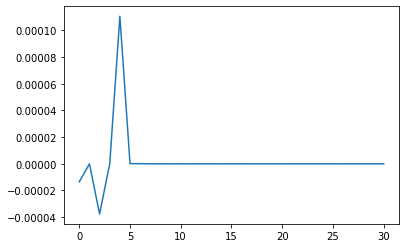

In [30]:
plt.plot(pipeline['lr'].coef_.flatten())

Loss: 2248


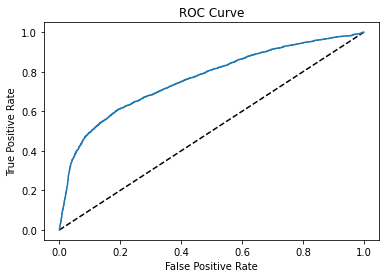

Model Accuracy=80.47
{'The more lift we have the larger the area under the curve'}


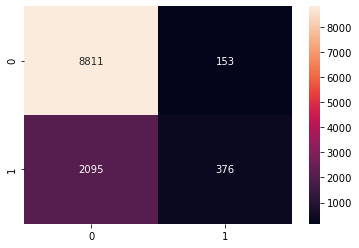

In [31]:
def my_loss(y,w):
    s = 0
    for i in range(y.size):
        # Get the true and predicted target values for example 'i'
        y_i_true = y[i]
        y_i_pred = w[i]
        s = s + (y_i_true - y_i_pred)**2
    return s

print("Loss:",my_loss(np.array(y_test),predictions))

fpr, tpr, threshholds = roc_curve(y_test,y_pred_prob[:,1])

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

accuracy=round(pipeline['lr'].score(X_train, y_train) * 100, 2)

print("Model Accuracy={accuracy}".format(accuracy=accuracy))

cm=confusion_matrix(y_test,predictions)

sns.heatmap(cm,annot=True,fmt="g")

print({"The more lift we have the larger the area under the curve"})

In [32]:
scaler=StandardScaler()
searcher = GridSearchCV(pipeline['lr'], {'C':[0.001, 0.01, 0.1, 1, 10],'tol':[0.001,0.0001,0.01,0.1,0.05,2,3]})
searcher.fit(scaler.fit_transform(X_train), y_train)

print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)

Best CV params {'C': 0.01, 'tol': 0.001}
Best CV accuracy 1.0


Text(0.5, 1.0, 'Predictions based on probabilities threshold')

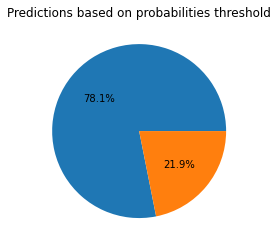

In [33]:
preds = pipeline['lr'].predict_proba(X_test)
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])
true_df=y_test
preds_df=pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1)
#print(preds_df)

#print("Actual defaults ", preds_df['loan_status'][preds_df['loan_status']==1].count())
#print("Predicted defaults ",preds_df['loan_status'][preds_df['prob_default']>=0.50].count())

threshold=0.35
preds_df['pred_loan_status']=preds_df['prob_default'].apply(lambda x: 1 if x>threshold else 0)
plt.pie(pd.Series(preds_df['pred_loan_status']).value_counts(),autopct='%1.1f%%')
plt.title("Predictions based on probabilities threshold")


In [34]:
print(classification_report(y_test,preds_df['pred_loan_status'], target_names=['Non default','Default']))

              precision    recall  f1-score   support

 Non default       0.87      0.87      0.87      8964
     Default       0.53      0.54      0.53      2471

    accuracy                           0.80     11435
   macro avg       0.70      0.70      0.70     11435
weighted avg       0.80      0.80      0.80     11435



Instructions for updating:
Colocations handled automatically by placer.


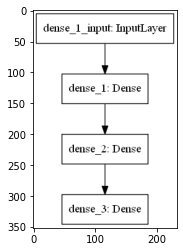

In [35]:
#https://www.bmc.com/blogs/keras-neural-network-classification/
model = Sequential()
model.add(Dense(len(COLUMNS), input_shape=(len(COLUMNS),),
               activation='tanh'
               ))
model.add(Dense(len(COLUMNS),activation='tanh'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])



plot_model(model, to_file='model.png')
img=plt.imread('model.png')
plt.imshow(img)
plt.show()


In [36]:
scaler=StandardScaler()
scaler.fit(X)
X2=scaler.transform(X)

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history=model.fit(X,y, epochs = 20,verbose=1)
#history=model.fit(X_train,y_train,  epochs = 600)

# Evaluate your model 
print("Final lost value:",model.evaluate(X2,y))



Instructions for updating:
Use tf.cast instead.
Epoch 1/20
28586/28586 [==============================] - 1s 29us/step - loss: 0.4923 - accuracy: 0.7892
Epoch 2/20
28586/28586 [==============================] - 1s 24us/step - loss: 0.4547 - accuracy: 0.8173
Epoch 3/20
28586/28586 [==============================] - 1s 24us/step - loss: 0.4475 - accuracy: 0.8252
Epoch 4/20
28586/28586 [==============================] - 1s 24us/step - loss: 0.4420 - accuracy: 0.8270
Epoch 5/20
28586/28586 [==============================] - 1s 23us/step - loss: 0.4413 - accuracy: 0.8263 0s - loss: 0.4433 - accuracy
Epoch 6/20
28586/28586 [==============================] - 1s 24us/step - loss: 0.4393 - accuracy: 0.8255
Epoch 7/20
28586/28586 [==============================] - 1s 24us/step - loss: 0.4376 - accuracy: 0.8299
Epoch 8/20
28586/28586 [==============================] - 1s 25us/step - loss: 0.4385 - accuracy: 0.8271
Epoch 9/20
28586/28586 [==============================] - 1s 26us/step - loss: 0.43

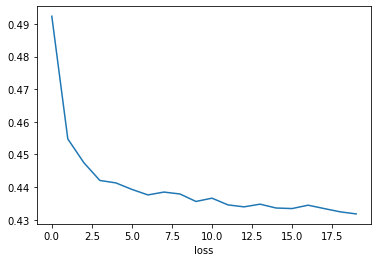

In [37]:
plt.figure()
plt.plot(history.history['loss'])
plt.xlabel('loss')
plt.show()

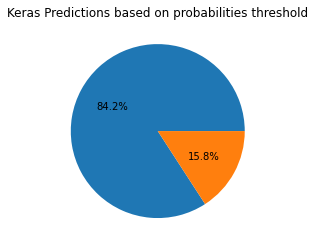

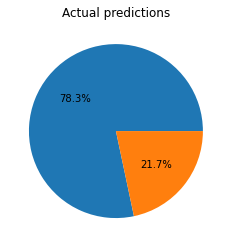

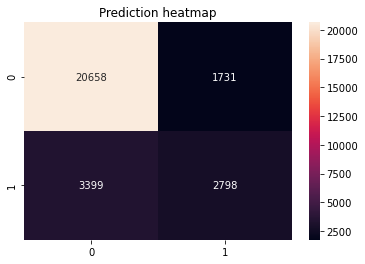

In [38]:
threshold=.275
prediction = model.predict(X[COLUMNS])
#print(prediction)

preds_df = pd.DataFrame(prediction, columns = ['pred_default_proba'])
true_df=y
preds_df=pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1)

preds_df['pred_loan_status']=preds_df['pred_default_proba'].apply(lambda row: 1 if row >threshold else 0)

plt.pie(preds_df['pred_loan_status'].value_counts(),autopct='%1.1f%%')
plt.title("Keras Predictions based on probabilities threshold")
plt.show()

plt.pie(preds_df['loan_status'].value_counts(),autopct='%1.1f%%')
plt.title("Actual predictions")
plt.show()    

cm=confusion_matrix(y,preds_df['pred_loan_status'])
sns.heatmap(cm,annot=True,fmt='g')
plt.title('Prediction heatmap')
plt.show()

In [39]:
# Print all the non-average values from the report
print(precision_recall_fscore_support(y,preds_df["pred_loan_status"])[0])

print(classification_report(y, preds_df['pred_loan_status'], target_names=['Non default','Default']))

[0.85871056 0.61779642]
              precision    recall  f1-score   support

 Non default       0.86      0.92      0.89     22389
     Default       0.62      0.45      0.52      6197

    accuracy                           0.82     28586
   macro avg       0.74      0.69      0.71     28586
weighted avg       0.81      0.82      0.81     28586



In [40]:
default_count=(X[X['loan_status']==1]['loan_status'].sum())
avg_loan_amt=(X[X['loan_status']==1]['loan_amnt'].mean())

avg_loan_non_default_amt=(X[X['loan_status']==0]['loan_amnt'].mean())

print("Actual Default count {} Avg loan Amt {} Non default avg loant amt {}".format(default_count,avg_loan_amt,avg_loan_non_default_amt))

Actual Default count 6197 Avg loan Amt 11011.110214619977 Non default avg loant amt 9271.231408280852


In [41]:
pred_default_count=preds_df[preds_df['pred_loan_status']==1]['pred_loan_status'].sum()
print("Predicted Default count {}".format(pred_default_count))

Predicted Default count 4529


In [42]:
xg_cl= xgb.XGBClassifier(objective='binary:logistic',n_estimators=10,seed=123)

xg_cl.fit(X_train,y_train)


[06:50:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=4, num_parallel_tree=1, random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Predicted fraud count  2471


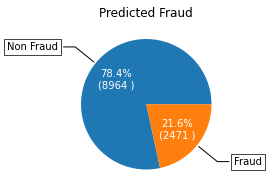

0    0
1    0
2    0
3    0
4    1
Name: loan_status, dtype: int64
0.02232876792550087 75000.0 
0.02232876792550087 40000.0 
0.02232876792550087 133800.0 
0.02232876792550087 84240.0 
0.9774956703186035 101000.0 
0.02232876792550087 90000.0 
0.9774956703186035 27000.0 
0.02232876792550087 28800.0 
0.9774956703186035 33000.0 
0.02232876792550087 42000.0 
0.9774956703186035 31800.0 
0.02232876792550087 96000.0 
0.9774956703186035 58650.0 
0.02232876792550087 112200.0 
0.02232876792550087 12996.0 
0.9774956703186035 33000.0 
0.02232876792550087 90000.0 
0.02232876792550087 83000.0 
0.02232876792550087 72500.0 
0.02232876792550087 85000.0 
0.9774956703186035 45000.0 
0.02232876792550087 51395.0 
0.02232876792550087 26729.0 
0.02232876792550087 28672.0 
0.02232876792550087 89849.0 
0.02232876792550087 43000.0 
0.02232876792550087 52800.0 
0.02232876792550087 99996.0 
0.02232876792550087 45000.0 
0.02232876792550087 65000.0 
0.02232876792550087 60000.0 
0.02232876792550087 39000.0 
0.0223287

0.9774956703186035 74000.0 
0.02232876792550087 53000.0 
0.9774956703186035 12996.0 
0.9774956703186035 52000.0 
0.9774956703186035 15000.0 
0.9774956703186035 34000.0 
0.02232876792550087 37400.0 
0.02232876792550087 35000.0 
0.02232876792550087 43000.0 
0.02232876792550087 72000.0 
0.02232876792550087 226000.0 
0.02232876792550087 50433.0 
0.02232876792550087 70000.0 
0.02232876792550087 61000.0 
0.02232876792550087 17676.0 
0.02232876792550087 62000.0 
0.02232876792550087 65000.0 
0.02232876792550087 48000.0 
0.02232876792550087 74000.0 
0.02232876792550087 47000.0 
0.02232876792550087 54000.0 
0.02232876792550087 62200.0 
0.02232876792550087 74000.0 
0.9774956703186035 45000.0 
0.9774956703186035 61000.0 
0.02232876792550087 89004.0 
0.02232876792550087 51300.0 
0.9774956703186035 32900.0 
0.02232876792550087 69996.0 
0.02232876792550087 115000.0 
0.02232876792550087 47000.0 
0.9774956703186035 31700.0 
0.02232876792550087 24000.0 
0.02232876792550087 79800.0 
0.02232876792550087 2

0.02232876792550087 146000.0 
0.02232876792550087 135000.0 
0.02232876792550087 50000.0 
0.9774956703186035 44000.0 
0.9774956703186035 39996.0 
0.02232876792550087 200000.0 
0.02232876792550087 64000.0 
0.9774956703186035 21000.0 
0.02232876792550087 45000.0 
0.02232876792550087 85000.0 
0.02232876792550087 53500.0 
0.02232876792550087 48000.0 
0.02232876792550087 95000.0 
0.02232876792550087 107800.0 
0.02232876792550087 50000.0 
0.02232876792550087 35100.0 
0.02232876792550087 100000.0 
0.02232876792550087 130000.0 
0.9774956703186035 73000.0 
0.02232876792550087 60000.0 
0.02232876792550087 90000.0 
0.9774956703186035 33666.0 
0.02232876792550087 60900.0 
0.02232876792550087 56000.0 
0.02232876792550087 39996.0 
0.9774956703186035 36000.0 
0.9774956703186035 38016.0 
0.02232876792550087 33000.0 
0.02232876792550087 57000.0 
0.02232876792550087 305000.0 
0.02232876792550087 69000.0 
0.02232876792550087 40000.0 
0.9774956703186035 32000.0 
0.02232876792550087 60000.0 
0.0223287679255

0.9774956703186035 38272.0 
0.9774956703186035 81400.0 
0.02232876792550087 66000.0 
0.02232876792550087 45000.0 
0.02232876792550087 84996.0 
0.02232876792550087 52000.0 
0.9774956703186035 75000.0 
0.02232876792550087 50000.0 
0.02232876792550087 110000.0 
0.02232876792550087 62000.0 
0.02232876792550087 96384.0 
0.02232876792550087 78000.0 
0.9774956703186035 15000.0 
0.02232876792550087 72000.0 
0.02232876792550087 57335.0 
0.02232876792550087 150000.0 
0.02232876792550087 95000.0 
0.02232876792550087 39000.0 
0.02232876792550087 79000.0 
0.9774956703186035 44000.0 
0.02232876792550087 30000.0 
0.02232876792550087 140000.0 
0.02232876792550087 57700.0 
0.02232876792550087 38400.0 
0.02232876792550087 30000.0 
0.9774956703186035 44000.0 
0.9774956703186035 40000.0 
0.02232876792550087 60000.0 
0.02232876792550087 88000.0 
0.02232876792550087 100000.0 
0.02232876792550087 75000.0 
0.02232876792550087 45000.0 
0.02232876792550087 61289.0 
0.02232876792550087 74678.0 
0.022328767925500

0.02232876792550087 42000.0 
0.02232876792550087 62000.0 
0.9774956703186035 36140.0 
0.02232876792550087 96500.0 
0.02232876792550087 14400.0 
0.02232876792550087 88712.0 
0.02232876792550087 64777.0 
0.02232876792550087 78000.0 
0.02232876792550087 75000.0 
0.02232876792550087 75000.0 
0.02232876792550087 70000.0 
0.02232876792550087 32500.0 
0.9774956703186035 73000.0 
0.02232876792550087 29534.0 
0.02232876792550087 120000.0 
0.02232876792550087 120000.0 
0.02232876792550087 66000.0 
0.9774956703186035 54000.0 
0.02232876792550087 41000.0 
0.02232876792550087 31200.0 
0.02232876792550087 146990.0 
0.02232876792550087 70000.0 
0.02232876792550087 25000.0 
0.02232876792550087 55000.0 
0.02232876792550087 64600.0 
0.02232876792550087 120000.0 
0.02232876792550087 24000.0 
0.02232876792550087 58000.0 
0.9774956703186035 69000.0 
0.02232876792550087 90000.0 
0.02232876792550087 50000.0 
0.02232876792550087 115000.0 
0.02232876792550087 69592.0 
0.02232876792550087 90000.0 
0.02232876792

0.02232876792550087 70000.0 
0.02232876792550087 53000.0 
0.02232876792550087 37500.0 
0.02232876792550087 95000.0 
0.02232876792550087 35000.0 
0.02232876792550087 60000.0 
0.02232876792550087 45000.0 
0.02232876792550087 80000.0 
0.9774956703186035 80750.0 
0.02232876792550087 62000.0 
0.02232876792550087 20000.0 
0.02232876792550087 120000.0 
0.02232876792550087 50000.0 
0.02232876792550087 104000.0 
0.02232876792550087 46873.0 
0.02232876792550087 44894.0 
0.02232876792550087 56000.0 
0.02232876792550087 51996.0 
0.02232876792550087 40000.0 
0.02232876792550087 30000.0 
0.02232876792550087 110000.0 
0.9774956703186035 54000.0 
0.9774956703186035 10000.0 
0.02232876792550087 82000.0 
0.02232876792550087 40000.0 
0.02232876792550087 202000.0 
0.9774956703186035 52000.0 
0.02232876792550087 75000.0 
0.02232876792550087 51000.0 
0.02232876792550087 90000.0 
0.02232876792550087 70000.0 
0.02232876792550087 60000.0 
0.9774956703186035 27600.0 
0.02232876792550087 17688.0 
0.0223287679255

0.9774956703186035 91800.0 
0.02232876792550087 140000.0 
0.02232876792550087 105000.0 
0.02232876792550087 76000.0 
0.02232876792550087 40000.0 
0.02232876792550087 39996.0 
0.02232876792550087 80000.0 
0.02232876792550087 60000.0 
0.9774956703186035 36000.0 
0.02232876792550087 85000.0 
0.02232876792550087 75670.0 
0.9774956703186035 58650.0 
0.9774956703186035 76500.0 
0.02232876792550087 96500.0 
0.02232876792550087 62300.0 
0.02232876792550087 84000.0 
0.02232876792550087 115000.0 
0.02232876792550087 44004.0 
0.02232876792550087 94000.0 
0.9774956703186035 64000.0 
0.02232876792550087 45000.0 
0.9774956703186035 46000.0 
0.02232876792550087 106000.0 
0.02232876792550087 94000.0 
0.02232876792550087 60000.0 
0.02232876792550087 75000.0 
0.02232876792550087 80000.0 
0.02232876792550087 45000.0 
0.9774956703186035 37000.0 
0.02232876792550087 52000.0 
0.02232876792550087 19200.0 
0.02232876792550087 180000.0 
0.02232876792550087 65000.0 
0.02232876792550087 28000.0 
0.02232876792550

0.02232876792550087 85000.0 
0.9774956703186035 53800.0 
0.02232876792550087 52800.0 
0.02232876792550087 150000.0 
0.02232876792550087 105000.0 
0.02232876792550087 73000.0 
0.9774956703186035 31513.0 
0.02232876792550087 50000.0 
0.02232876792550087 28800.0 
0.9774956703186035 96050.0 
0.02232876792550087 50000.0 
0.9774956703186035 28800.0 
0.02232876792550087 52692.0 
0.02232876792550087 31200.0 
0.02232876792550087 120000.0 
0.02232876792550087 70000.0 
0.02232876792550087 40000.0 
0.02232876792550087 48732.0 
0.02232876792550087 49000.0 
0.9774956703186035 98000.0 
0.02232876792550087 40000.0 
0.02232876792550087 90000.0 
0.02232876792550087 73992.0 
0.02232876792550087 60000.0 
0.9774956703186035 66000.0 
0.02232876792550087 81000.0 
0.02232876792550087 43000.0 
0.02232876792550087 40000.0 
0.02232876792550087 24996.0 
0.9774956703186035 39000.0 
0.02232876792550087 120000.0 
0.9774956703186035 98000.0 
0.02232876792550087 46680.0 
0.02232876792550087 96000.0 
0.0223287679255008

0.02232876792550087 26400.0 
0.9774956703186035 27996.0 
0.02232876792550087 75996.0 
0.9774956703186035 65000.0 
0.9774956703186035 89000.0 
0.02232876792550087 50000.0 
0.02232876792550087 35004.0 
0.02232876792550087 32000.0 
0.02232876792550087 51600.0 
0.02232876792550087 52000.0 
0.02232876792550087 55530.0 
0.02232876792550087 102000.0 
0.02232876792550087 84000.0 
0.9774956703186035 33000.0 
0.9774956703186035 34800.0 
0.02232876792550087 60000.0 
0.9774956703186035 67150.0 
0.02232876792550087 22004.0 
0.02232876792550087 93492.0 
0.9774956703186035 42000.0 
0.02232876792550087 275004.0 
0.02232876792550087 27000.0 
0.02232876792550087 90000.0 
0.02232876792550087 34400.0 
0.02232876792550087 58000.0 
0.9774956703186035 52650.0 
0.02232876792550087 65000.0 
0.02232876792550087 64000.0 
0.9774956703186035 34000.0 
0.02232876792550087 74500.0 
0.02232876792550087 100000.0 
0.02232876792550087 109488.0 
0.02232876792550087 62000.0 
0.02232876792550087 70000.0 
0.02232876792550087

0.02232876792550087 35000.0 
0.02232876792550087 58000.0 
0.02232876792550087 88000.0 
0.02232876792550087 60000.0 
0.9774956703186035 56100.0 
0.02232876792550087 86000.0 
0.02232876792550087 50000.0 
0.9774956703186035 78000.0 
0.02232876792550087 68000.0 
0.9774956703186035 68400.0 
0.9774956703186035 148000.0 
0.02232876792550087 67000.0 
0.02232876792550087 88000.0 
0.02232876792550087 68000.0 
0.9774956703186035 62900.0 
0.02232876792550087 113000.0 
0.02232876792550087 38400.0 
0.02232876792550087 51600.0 
0.02232876792550087 99000.0 
0.02232876792550087 58000.0 
0.02232876792550087 46700.0 
0.02232876792550087 34000.0 
0.02232876792550087 220000.0 
0.02232876792550087 43680.0 
0.02232876792550087 55000.0 
0.02232876792550087 55000.0 
0.02232876792550087 24996.0 
0.02232876792550087 90000.0 
0.02232876792550087 105000.0 
0.02232876792550087 40000.0 
0.02232876792550087 55000.0 
0.02232876792550087 57564.0 
0.02232876792550087 37000.0 
0.02232876792550087 60000.0 
0.0223287679255

0.9774956703186035 51600.0 
0.9774956703186035 39000.0 
0.02232876792550087 83004.0 
0.02232876792550087 58000.0 
0.02232876792550087 86400.0 
0.02232876792550087 61000.0 
0.02232876792550087 67775.0 
0.02232876792550087 42000.0 
0.02232876792550087 60000.0 
0.02232876792550087 35640.0 
0.02232876792550087 28800.0 
0.02232876792550087 114000.0 
0.9774956703186035 39000.0 
0.9774956703186035 88400.0 
0.02232876792550087 85000.0 
0.02232876792550087 60000.0 
0.9774956703186035 39000.0 
0.9774956703186035 27000.0 
0.02232876792550087 36000.0 
0.02232876792550087 42000.0 
0.02232876792550087 55259.0 
0.9774956703186035 47000.0 
0.02232876792550087 42000.0 
0.02232876792550087 54000.0 
0.02232876792550087 26400.0 
0.02232876792550087 80196.0 
0.02232876792550087 122000.0 
0.02232876792550087 32000.0 
0.02232876792550087 58000.0 
0.02232876792550087 84000.0 
0.02232876792550087 75000.0 
0.02232876792550087 35600.0 
0.02232876792550087 85000.0 
0.02232876792550087 57000.0 
0.9774956703186035 

0.02232876792550087 66000.0 
0.02232876792550087 125000.0 
0.9774956703186035 29004.0 
0.02232876792550087 86000.0 
0.02232876792550087 92004.0 
0.02232876792550087 36000.0 
0.02232876792550087 70596.0 
0.9774956703186035 33100.0 
0.02232876792550087 130000.0 
0.02232876792550087 60000.0 
0.02232876792550087 185000.0 
0.02232876792550087 62400.0 
0.02232876792550087 45600.0 
0.9774956703186035 38004.0 
0.02232876792550087 51000.0 
0.02232876792550087 75000.0 
0.02232876792550087 112732.0 
0.9774956703186035 32484.0 
0.9774956703186035 30000.0 
0.02232876792550087 55000.0 
0.02232876792550087 52000.0 
0.02232876792550087 87000.0 
0.02232876792550087 135000.0 
0.02232876792550087 65000.0 
0.02232876792550087 62500.0 
0.02232876792550087 78000.0 
0.02232876792550087 50000.0 
0.02232876792550087 44500.0 
0.02232876792550087 87000.0 
0.02232876792550087 48504.0 
0.9774956703186035 118000.0 
0.02232876792550087 15360.0 
0.9774956703186035 21600.0 
0.02232876792550087 46000.0 
0.0223287679255

0.02232876792550087 120000.0 
0.02232876792550087 56000.0 
0.9774956703186035 71400.0 
0.02232876792550087 50000.0 
0.02232876792550087 85000.0 
0.9774956703186035 18200.0 
0.02232876792550087 90000.0 
0.02232876792550087 120000.0 
0.02232876792550087 71700.0 
0.02232876792550087 140000.0 
0.02232876792550087 123000.0 
0.9774956703186035 34320.0 
0.02232876792550087 60000.0 
0.02232876792550087 25000.0 
0.02232876792550087 42000.0 
0.02232876792550087 105000.0 
0.02232876792550087 55000.0 
0.02232876792550087 125000.0 
0.02232876792550087 97700.0 
0.02232876792550087 75000.0 
0.02232876792550087 74000.0 
0.02232876792550087 42000.0 
0.02232876792550087 42000.0 
0.9774956703186035 9600.0 
0.02232876792550087 28800.0 
0.02232876792550087 35000.0 
0.02232876792550087 70000.0 
0.02232876792550087 50000.0 
0.02232876792550087 59000.0 
0.02232876792550087 26500.0 
0.02232876792550087 30000.0 
0.02232876792550087 70000.0 
0.02232876792550087 37000.0 
0.02232876792550087 105000.0 
0.0223287679

0.02232876792550087 120000.0 
0.02232876792550087 75400.0 
0.02232876792550087 55000.0 
0.02232876792550087 124000.0 
0.02232876792550087 32000.0 
0.02232876792550087 95000.0 
0.02232876792550087 46000.0 
0.9774956703186035 30500.0 
0.02232876792550087 75000.0 
0.02232876792550087 120000.0 
0.02232876792550087 70000.0 
0.02232876792550087 93000.0 
0.9774956703186035 54000.0 
0.02232876792550087 48000.0 
0.9774956703186035 54000.0 
0.02232876792550087 36000.0 
0.02232876792550087 32400.0 
0.02232876792550087 28800.0 
0.9774956703186035 66000.0 
0.02232876792550087 45000.0 
0.02232876792550087 92259.0 
0.02232876792550087 30000.0 
0.9774956703186035 65000.0 
0.9774956703186035 66300.0 
0.9774956703186035 15600.0 
0.02232876792550087 60000.0 
0.9774956703186035 50000.0 
0.02232876792550087 83000.0 
0.02232876792550087 40000.0 
0.02232876792550087 72000.0 
0.02232876792550087 95000.0 
0.02232876792550087 130000.0 
0.9774956703186035 31000.0 
0.02232876792550087 81960.0 
0.02232876792550087

0.9774956703186035 38400.0 
0.02232876792550087 83000.0 
0.02232876792550087 33280.0 
0.9774956703186035 34000.0 
0.02232876792550087 100000.0 
0.9774956703186035 20000.0 
0.02232876792550087 119000.0 
0.02232876792550087 68000.0 
0.02232876792550087 52809.0 
0.9774956703186035 26000.0 
0.9774956703186035 55000.0 
0.02232876792550087 100000.0 
0.9774956703186035 26237.0 
0.02232876792550087 89000.0 
0.02232876792550087 137000.0 
0.02232876792550087 19200.0 
0.02232876792550087 108000.0 
0.02232876792550087 22812.0 
0.9774956703186035 41500.0 
0.02232876792550087 95000.0 
0.02232876792550087 52500.0 
0.02232876792550087 46000.0 
0.02232876792550087 30000.0 
0.02232876792550087 70000.0 
0.9774956703186035 60000.0 
0.02232876792550087 58239.0 
0.02232876792550087 42000.0 
0.02232876792550087 66500.0 
0.02232876792550087 15600.0 
0.02232876792550087 70000.0 
0.02232876792550087 40000.0 
0.02232876792550087 118300.0 
0.02232876792550087 21600.0 
0.02232876792550087 41004.0 
0.97749567031860

0.02232876792550087 41500.0 
0.02232876792550087 105804.0 
0.02232876792550087 64000.0 
0.02232876792550087 90000.0 
0.02232876792550087 66000.0 
0.02232876792550087 73440.0 
0.02232876792550087 95004.0 
0.02232876792550087 49304.0 
0.02232876792550087 55000.0 
0.02232876792550087 58000.0 
0.02232876792550087 45000.0 
0.02232876792550087 50004.0 
0.02232876792550087 105398.0 
0.02232876792550087 30000.0 
0.02232876792550087 45000.0 
0.02232876792550087 50000.0 
0.02232876792550087 42000.0 
0.9774956703186035 53295.0 
0.02232876792550087 240000.0 
0.02232876792550087 48000.0 
0.02232876792550087 72000.0 
0.9774956703186035 27000.0 
0.02232876792550087 96000.0 
0.9774956703186035 43000.0 
0.9774956703186035 23700.0 
0.02232876792550087 102000.0 
0.02232876792550087 41000.0 
0.02232876792550087 70000.0 
0.02232876792550087 80000.0 
0.02232876792550087 82000.0 
0.9774956703186035 142800.0 
0.02232876792550087 125000.0 
0.02232876792550087 50123.0 
0.9774956703186035 62900.0 
0.022328767925

0.02232876792550087 55000.0 
0.02232876792550087 43300.0 
0.02232876792550087 60000.0 
0.02232876792550087 40000.0 
0.9774956703186035 10000.0 
0.02232876792550087 34500.0 
0.02232876792550087 57600.0 
0.02232876792550087 24996.0 
0.9774956703186035 26000.0 
0.02232876792550087 72000.0 
0.02232876792550087 44304.0 
0.02232876792550087 74400.0 
0.9774956703186035 35000.0 
0.9774956703186035 44172.0 
0.02232876792550087 100000.0 
0.02232876792550087 30000.0 
0.02232876792550087 50000.0 
0.02232876792550087 40000.0 
0.02232876792550087 58000.0 
0.9774956703186035 30000.0 
0.9774956703186035 78000.0 
0.9774956703186035 91800.0 
0.02232876792550087 35004.0 
0.02232876792550087 76000.0 
0.9774956703186035 83000.0 
0.02232876792550087 80000.0 
0.02232876792550087 95004.0 
0.9774956703186035 36000.0 
0.9774956703186035 46272.0 
0.9774956703186035 33000.0 
0.02232876792550087 84000.0 
0.9774956703186035 40000.0 
0.02232876792550087 94000.0 
0.02232876792550087 105000.0 
0.02232876792550087 6000

0.02232876792550087 89523.0 
0.02232876792550087 58000.0 
0.02232876792550087 100000.0 
0.02232876792550087 52000.0 
0.9774956703186035 20000.0 
0.02232876792550087 35000.0 
0.02232876792550087 80000.0 
0.02232876792550087 25000.0 
0.02232876792550087 60000.0 
0.02232876792550087 66912.0 
0.02232876792550087 57600.0 
0.9774956703186035 29000.0 
0.02232876792550087 32000.0 
0.02232876792550087 80004.0 
0.02232876792550087 150000.0 
0.02232876792550087 66996.0 
0.02232876792550087 15000.0 
0.02232876792550087 102000.0 
0.9774956703186035 36000.0 
0.9774956703186035 58000.0 
0.02232876792550087 40000.0 
0.02232876792550087 90722.0 
0.02232876792550087 30000.0 
0.02232876792550087 52000.0 
0.02232876792550087 80000.0 
0.02232876792550087 50000.0 
0.02232876792550087 68000.0 
0.02232876792550087 70000.0 
0.02232876792550087 170000.0 
0.02232876792550087 110000.0 
0.02232876792550087 44500.0 
0.9774956703186035 81000.0 
0.02232876792550087 100000.0 
0.02232876792550087 84000.0 
0.97749567031

0.02232876792550087 35000.0 
0.02232876792550087 33600.0 
0.02232876792550087 92000.0 
0.02232876792550087 50000.0 
0.02232876792550087 36000.0 
0.02232876792550087 102000.0 
0.02232876792550087 100000.0 
0.9774956703186035 29000.0 
0.9774956703186035 238000.0 
0.02232876792550087 67600.0 
0.02232876792550087 45000.0 
0.02232876792550087 63402.0 
0.02232876792550087 94000.0 
0.02232876792550087 100000.0 
0.9774956703186035 64000.0 
0.02232876792550087 68000.0 
0.02232876792550087 67000.0 
0.02232876792550087 46000.0 
0.02232876792550087 37500.0 
0.02232876792550087 60000.0 
0.02232876792550087 72000.0 
0.02232876792550087 130000.0 
0.9774956703186035 35000.0 
0.02232876792550087 62000.0 
0.02232876792550087 30720.0 
0.02232876792550087 70000.0 
0.02232876792550087 65004.0 
0.02232876792550087 117000.0 
0.02232876792550087 30000.0 
0.9774956703186035 54000.0 
0.02232876792550087 35000.0 
0.02232876792550087 52500.0 
0.02232876792550087 30000.0 
0.02232876792550087 72000.0 
0.02232876792

0.02232876792550087 14400.0 
0.02232876792550087 55000.0 
0.02232876792550087 19200.0 
0.02232876792550087 42000.0 
0.02232876792550087 65000.0 
0.02232876792550087 48000.0 
0.9774956703186035 33600.0 
0.02232876792550087 72000.0 
0.02232876792550087 104000.0 
0.9774956703186035 60000.0 
0.02232876792550087 40000.0 
0.02232876792550087 43000.0 
0.9774956703186035 29000.0 
0.02232876792550087 91000.0 
0.02232876792550087 75000.0 
0.02232876792550087 71688.0 
0.02232876792550087 172500.0 
0.9774956703186035 13806.0 
0.9774956703186035 66000.0 
0.9774956703186035 31732.0 
0.02232876792550087 140000.0 
0.02232876792550087 81000.0 
0.02232876792550087 94992.0 
0.02232876792550087 57500.0 
0.02232876792550087 390000.0 
0.02232876792550087 96000.0 
0.02232876792550087 70000.0 
0.02232876792550087 36000.0 
0.02232876792550087 49200.0 
0.02232876792550087 45000.0 
0.02232876792550087 60000.0 
0.02232876792550087 85000.0 
0.9774956703186035 10800.0 
0.02232876792550087 43812.0 
0.977495670318603

0.02232876792550087 47000.0 
0.02232876792550087 60000.0 
0.02232876792550087 60000.0 
0.02232876792550087 59617.0 
0.9774956703186035 30000.0 
0.9774956703186035 103000.0 
0.02232876792550087 65004.0 
0.02232876792550087 30000.0 
0.9774956703186035 39000.0 
0.02232876792550087 57996.0 
0.9774956703186035 44000.0 
0.02232876792550087 125000.0 
0.02232876792550087 117500.0 
0.02232876792550087 57000.0 
0.02232876792550087 40000.0 
0.02232876792550087 56000.0 
0.02232876792550087 45000.0 
0.02232876792550087 35000.0 
0.02232876792550087 130000.0 
0.02232876792550087 74004.0 
0.02232876792550087 99000.0 
0.9774956703186035 69996.0 
0.02232876792550087 70000.0 
0.02232876792550087 90000.0 
0.02232876792550087 72000.0 
0.02232876792550087 26124.0 
0.02232876792550087 98518.0 
0.02232876792550087 100000.0 
0.02232876792550087 30000.0 
0.02232876792550087 42769.0 
0.02232876792550087 89004.0 
0.02232876792550087 32000.0 
0.9774956703186035 40000.0 
0.02232876792550087 40000.0 
0.0223287679255

In [43]:
y_pred=xg_cl.predict(X_test)
y_pred_proba=xg_cl.predict_proba(X_test)

preds_proba_df = pd.DataFrame(y_pred_proba[:,1], columns = ['prob_default'])

print("Predicted fraud count ",len(y_pred[y_pred==1]))
buffer=pd.Series(y_pred)
#buffer.value_counts().plot(kind='pie')
#plt.show()

drawPieChart(['Non Fraud','Fraud'],buffer.value_counts(),"Predicted Fraud")

preds_df=pd.DataFrame(X_test)
#preds_df=preds_df.reset_index()
#true_df=pd.DataFrame(y_test['loan_status'],columns=['loan_status'])
preds_df=pd.concat([preds_df.reset_index(drop=True),preds_proba_df],axis=1)
preds_df.dropna(inplace=True)
print(preds_df['loan_status'].head())
for key,item  in preds_df.iterrows():
    #if item['loan_status']==1:
    print("{} {} ".format(item['prob_default'],item['person_income']))
